# Objetivo del ejercicio

Identificar y clasificar variables por escala de medición.
Aplicar transformaciones adecuadas (codificación, ordenamiento, tipados).
Realizar análisis descriptivo y visualización apropiados según cada escala.
Evitar errores comunes (p. ej., media en variables nominales).
Contexto: Encuesta de satisfacción de un servicio con datos demográficos y operativos.

Dataset simulado (columnas y escalas)

| Columna | Descripción | Escala |
| --- | --- | --- |
| id_cliente | Identificador único de cliente | Nominal (categórica sin orden) |
| genero | ‘F’, ‘M’, ‘No binario’, ‘Prefiero no decir’ | Nominal |
| segmento | ‘Estándar’, ‘Oro’, ‘Platino’ | Ordinal (estándar < oro < platino) |
| satisfaccion | Likert 1–5 | Ordinal |
| ciudad | Ciudad de residencia | Nominal |
| edad | Años | Razón |
| ingreso_mensual | Ingreso (MXN) | Razón |
| temperatura_sala | °C del lugar de atención | Intervalo |
| visitas_ultimo_anio | Número de visitas | Razón |
| fecha_ultima_visita | Fecha (Temporal; úsala para derivar razón/intervalo, p. ej., días desde…) |Intervalo / Razón |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n = 200

df = pd.DataFrame({
    "id_cliente": range(1, n+1),
    "genero": np.random.choice(["F", "M", "No binario", "Prefiero no decir"], size=n, p=[0.45, 0.45, 0.05, 0.05]),
    "segmento": np.random.choice(["Estándar", "Oro", "Platino"], size=n, p=[0.6, 0.3, 0.1]),
    "satisfaccion": np.random.choice([1,2,3,4,5], size=n, p=[0.1,0.2,0.35,0.25,0.1]),
    "ciudad": np.random.choice(["SLP", "CDMX", "GDL", "MTY", "QRO"], size=n, p=[0.35,0.25,0.15,0.15,0.10]),
    "edad": np.random.normal(35, 10, size=n).round(0).clip(18, 70).astype(int),
    "ingreso_mensual": np.random.lognormal(mean=9.5, sigma=0.5, size=n).round(2), # pesos MXN aprox.
    "temperatura_sala": np.random.normal(23, 2, size=n).round(1),
    "visitas_ultimo_anio": np.random.poisson(lam=3, size=n),
    "fecha_ultima_visita": pd.to_datetime("2025-12-31") - pd.to_timedelta(np.random.randint(0, 365, size=n), unit="D")
})

df.head()

,id_cliente,genero,segmento,satisfaccion,ciudad,edad,ingreso_mensual,temperatura_sala,visitas_ultimo_anio,fecha_ultima_visita
0,1,F,Oro,2,SLP,27,10315.01,24.0,4,2025-04-08
1,2,Prefiero no decir,Estándar,5,SLP,40,27029.22,21.9,1,2025-05-11
2,3,M,Estándar,3,SLP,54,42169.36,23.0,3,2025-02-14
3,4,M,Oro,4,SLP,48,11143.16,27.3,4,2025-02-24
4,5,F,Oro,3,SLP,51,10691.98,26.5,6,2025-03-06


## 2) Tipado correcto por escala
Nominal: genero, ciudad, id_cliente (como identificador, no lo analices).
Ordinal: segmento, satisfaccion (con orden definido).
Intervalo: temperatura_sala (°C tiene 0 arbitrario; diferencias sí tienen sentido).
Razón: edad, ingreso_mensual, visitas_ultimo_anio (tienen cero absoluto y proporciones).


In [2]:
# Nominal → category (sin orden)
df["genero"] = df["genero"].astype("category")
df["ciudad"] = df["ciudad"].astype("category")

# Ordinal → category con orden
segmento_cat = pd.CategoricalDtype(categories=["Estándar", "Oro", "Platino"], ordered=True)
df["segmento"] = df["segmento"].astype(segmento_cat)

satisfaccion_cat = pd.CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
df["satisfaccion"] = df["satisfaccion"].astype(satisfaccion_cat)

# Intervalo / Razón → numérico (ya están), pero verifica:
df["temperatura_sala"] = pd.to_numeric(df["temperatura_sala"])
df["edad"] = pd.to_numeric(df["edad"])
df["ingreso_mensual"] = pd.to_numeric(df["ingreso_mensual"])
df["visitas_ultimo_anio"] = pd.to_numeric(df["visitas_ultimo_anio"])

# Derivada útil: días desde última visita (razón)
df["dias_desde_ultima_visita"] = (pd.to_datetime("2025-12-31") - df["fecha_ultima_visita"]).dt.days

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_cliente                200 non-null    int64         
 1   genero                    200 non-null    category      
 2   segmento                  200 non-null    category      
 3   satisfaccion              200 non-null    category      
 4   ciudad                    200 non-null    category      
 5   edad                      200 non-null    int64         
 6   ingreso_mensual           200 non-null    float64       
 7   temperatura_sala          200 non-null    float64       
 8   visitas_ultimo_anio       200 non-null    int64         
 9   fecha_ultima_visita       200 non-null    datetime64[us]
 10  dias_desde_ultima_visita  200 non-null    int64         
dtypes: category(4), datetime64[us](1), float64(2), int64(4)
memory usage: 12.3 KB


## 3) Análisis descriptivo apropiado según escala
Nominal (frecuencias y proporciones):


In [3]:
freq_genero = df["genero"].value_counts().to_frame("frecuencia")
prop_genero = df["genero"].value_counts(normalize=True).round(3).to_frame("proporcion")
tabla_genero = freq_genero.join(prop_genero)
tabla_genero

,frecuencia,proporcion
genero,,
F,96,0.480
M,85,0.425
No binario,11,0.055
Prefiero no decir,8,0.040


Ordinal (distribución y tendencia central robusta — mediana):


In [4]:
dist_satisfaccion = df["satisfaccion"].value_counts().sort_index().to_frame("frecuencia")
mediana_satisfaccion = df["satisfaccion"].astype(int).median() # convertir para calcular
dist_segmento = df["segmento"].value_counts().sort_index().to_frame("frecuencia")
print(f"Mediana Satisfacción: {mediana_satisfaccion}")
display(dist_satisfaccion)
display(dist_segmento)

Mediana Satisfacción: 3.0


,frecuencia
satisfaccion,
1,23
2,33
3,71
4,43
5,30


,frecuencia
segmento,
Estándar,113
Oro,68
Platino,19


Intervalo (media, desviación, pero cuidado con cero):


In [5]:
temp_stats = df["temperatura_sala"].agg(["mean", "std", "min", "max"]).round(2)
temp_stats

mean    23.18
std      2.07
min     17.20
max     27.90
Name: temperatura_sala, dtype: float64

Razón (media, mediana, IQR, coeficiente de variación):


In [6]:
def resumen_razon(s):
    return pd.Series({
    "n": s.count(),
    "media": s.mean(),
    "mediana": s.median(),
    "sd": s.std(),
    "min": s.min(),
    "q1": s.quantile(0.25),
    "q3": s.quantile(0.75),
    "max": s.max(),
    "cv": s.std()/s.mean() if s.mean()!=0 else np.nan
    }).round(2)
    
razon_stats = pd.concat({
    "edad": resumen_razon(df["edad"]),
    "ingreso_mensual": resumen_razon(df["ingreso_mensual"]),
    "visitas_ultimo_anio": resumen_razon(df["visitas_ultimo_anio"]),
    "dias_desde_ultima_visita": resumen_razon(df["dias_desde_ultima_visita"])
    }, axis=1)
razon_stats

,edad,ingreso_mensual,visitas_ultimo_anio,dias_desde_ultima_visita
n,200.00,200.00,200.00,200.00
media,35.05,16258.11,2.96,188.99
mediana,35.00,14682.74,3.00,176.50
sd,9.61,8223.99,1.68,106.72
min,18.00,3976.11,0.00,4.00
q1,29.00,10201.25,2.00,100.75
q3,41.25,19436.38,4.00,283.25
max,61.00,47262.21,8.00,364.00
cv,0.27,0.51,0.57,0.56


## 4) Visualizaciones adecuadas por escala (opcional)


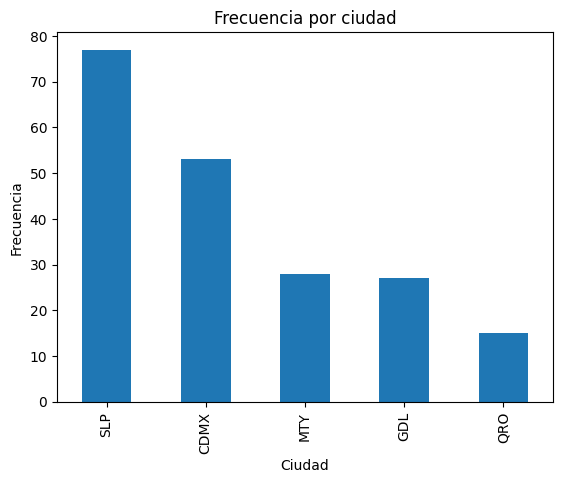

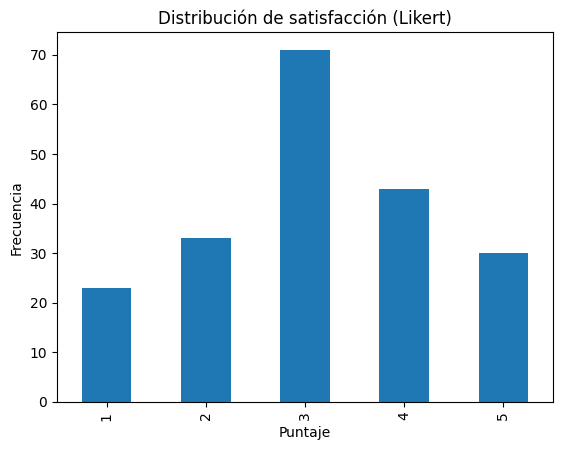

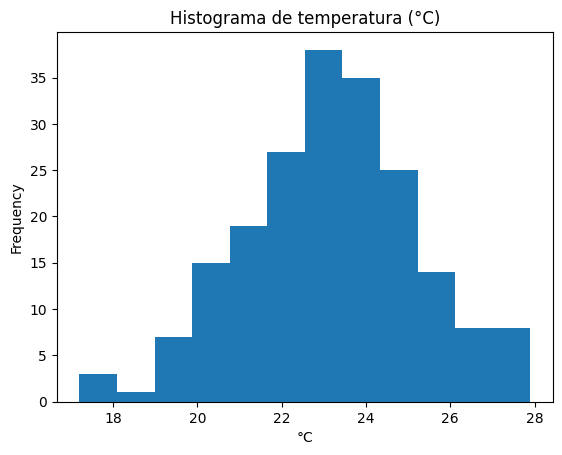

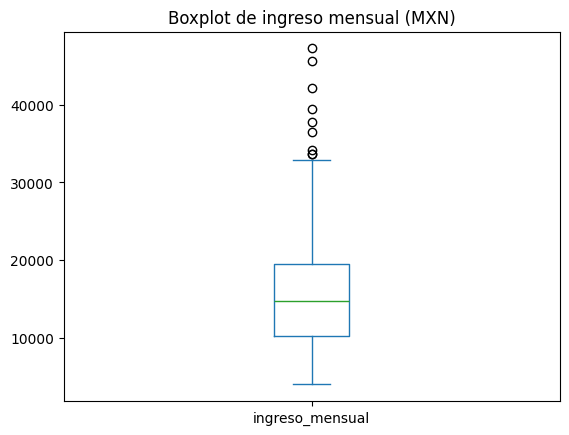

In [7]:
# Nominal: barras
df["ciudad"].value_counts().plot(kind="bar", title="Frecuencia por ciudad")
plt.xlabel("Ciudad"); plt.ylabel("Frecuencia"); plt.show()

# Ordinal: barra ordenada por categorías
df["satisfaccion"].value_counts().sort_index().plot(kind="bar", title="Distribución de satisfacción (Likert)")
plt.xlabel("Puntaje"); plt.ylabel("Frecuencia"); plt.show()

# Intervalo: histograma de temperatura
df["temperatura_sala"].plot(kind="hist", bins=12, title="Histograma de temperatura (°C)")
plt.xlabel("°C"); plt.show()

# Razón: boxplot de ingreso (suele ser asimétrico)
df[["ingreso_mensual"]].plot(kind="box", title="Boxplot de ingreso mensual (MXN)")
plt.show()

## 5) Cruces y análisis según escala
Nominal × Nominal: tabla de contingencia + chi-cuadrado (si procede).
Ordinal × Razón: comparar medias/medianas por categoría ordenada.
# Ordinal × Ordinal: asociación ordinal (p. ej., tendencia entre segmento y satisfaccion).


In [8]:
# Nominal × Nominal
ct_ciudad_genero = pd.crosstab(df["ciudad"], df["genero"], normalize="index").round(3)
display(ct_ciudad_genero)

# Ordinal × Razón (grupos por segmento)
ingreso_por_segmento = df.groupby("segmento", observed=False)["ingreso_mensual"].agg(["count","median","mean","std"]).round(2)
display(ingreso_por_segmento)

# Ordinal × Ordinal: correlación de Spearman entre satisfacción y segmento
spearman = df.assign(
satisfaccion_num = df["satisfaccion"].astype(int),
segmento_num = df["segmento"].cat.codes + 1 # Estándar=1, Oro=2, Platino=3
)[["satisfaccion_num","segmento_num"]].corr(method="spearman").iloc[0,1]
print(f"Correlación de Spearman: {spearman}")

genero,F,M,No binario,Prefiero no decir
ciudad,,,,
CDMX,0.453,0.415,0.094,0.038
GDL,0.407,0.556,0.037,0.000
MTY,0.571,0.393,0.000,0.036
QRO,0.600,0.400,0.000,0.000
SLP,0.468,0.403,0.065,0.065


,count,median,mean,std
segmento,,,,
Estándar,113,14721.22,16786.81,8411.56
Oro,68,13081.70,15383.05,7831.23
Platino,19,14786.38,16245.57,8634.75


Correlación de Spearman: -0.040233892283196265


## 6) Buenas prácticas (verificaciones)
No uses media para nominal/ordinal (excepto ordinal con precaución si tratas los valores como numéricos y lo justificas).
Para intervalo, evita hacer afirmaciones del tipo “el doble de temperatura” en °C.
Para razón, sí puedes hablar de proporciones y “el doble que…”.
Si hay outliers (p. ej., en ingreso_mensual), usa mediana o IQR además de la media.

### Reto adicional
Crea una variable binaria: alto_ingreso = ingreso_mensual >= Q3. (Nominal dicotómica)
Compara la distribución de satisfacción entre alto_ingreso=True/False con un gráfico de barras apiladas.
Calcula días_desde_ultima_visita por segmento y evalúa si hay tendencia.


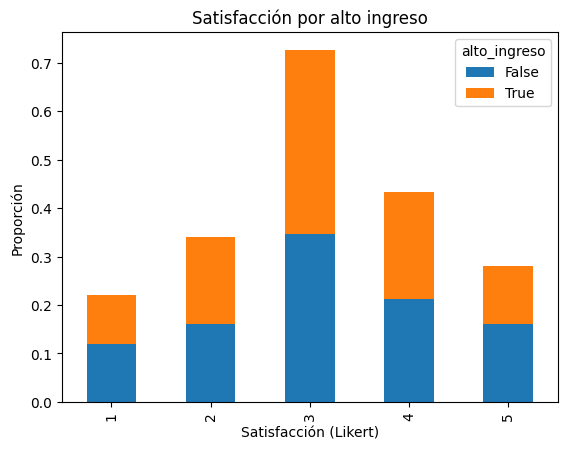

segmento
Estándar    171.0
Oro         189.0
Platino     183.0
Name: dias_desde_ultima_visita, dtype: float64

In [9]:
Q3 = df["ingreso_mensual"].quantile(0.75)
df["alto_ingreso"] = (df["ingreso_mensual"] >= Q3).astype("category")

# Barras apiladas: satisfacción x alto_ingreso
tabla = pd.crosstab(df["satisfaccion"], df["alto_ingreso"], normalize="columns").round(3)
tabla.plot(kind="bar", stacked=True, title="Satisfacción por alto ingreso")
plt.xlabel("Satisfacción (Likert)"); plt.ylabel("Proporción"); plt.show()

# Tendencia en días desde última visita por segmento
dias_seg = df.groupby("segmento", observed=False)["dias_desde_ultima_visita"].median()
dias_seg

## Preguntas guía para el informe
**¿Qué variables son nominales, ordinales, de intervalo y de razón? Da justificación breve.**

*   **Nominal:** `genero`, `ciudad`, `alto_ingreso`. Son categorías sin un orden intrínseco. `id_cliente` es un identificador.
*   **Ordinal:** `segmento`, `satisfaccion`. Tienen un orden lógico (e.g., Estándar < Oro < Platino).
*   **Intervalo:** `temperatura_sala`. El cero es arbitrario (0°C no significa ausencia de temperatura), pero las diferencias son significativas.
*   **Razón:** `edad`, `ingreso_mensual`, `visitas_ultimo_anio`, `dias_desde_ultima_visita`. Tienen un cero absoluto que indica ausencia de la variable, permitiendo comparaciones de proporción (e.g., doble de ingreso).

**¿Qué medidas resumen usaste para cada tipo y por qué?**

*   **Nominal:** Frecuencias absolutas y relativas (proporciones), ya que no tienen sentido medidas de tendencia central como la media.
*   **Ordinal:** Mediana y frecuencias. La media puede ser engañosa si los intervalos entre categorías no son iguales.
*   **Intervalo/Razón:** Media, mediana, desviación estándar, mínimo y máximo. Para razón, también se puede usar el coeficiente de variación.

**¿Qué hallazgos obtuviste al cruzar segmento con ingreso_mensual y con satisfaccion?**

*(Los hallazgos dependerán de la generación aleatoria de datos. Ejecutar el código para ver resultados específicos. Generalmente se busca ver si segmentos superiores (Oro, Platino) tienen mayores ingresos o satisfacción).*

**¿Hay asimetría notable en ingreso_mensual? ¿Cómo la trataste?**

*   Es común que el ingreso tenga una distribución asimétrica positiva (cola a la derecha). Se puede detectar comparando la media y la mediana. Si la media es mucho mayor que la mediana, hay asimetría. Se trata reportando la mediana y el rango intercuartílico (IQR) como medidas más robustas que la media y desviación estándar.

**¿Qué recomendarías al negocio con base en los resultados?**

*(Dependerá de los datos, ejemplo: Si la satisfacción es baja en el segmento 'Estándar', recomendar estrategias para mejorar la experiencia de este grupo mayoritario).*

---
### Glosario Adicional

**IQR (Rango Intercuartílico):** Medida de dispersión robusta que abarca el 50% central de los datos (Q3 - Q1). Útil para detectar outliers y entender la variabilidad sin la influencia de extremos.

**Coeficiente de Spearman:** Mide la correlación entre dos variables basándose en sus rangos (orden) en lugar de sus valores directos. Ideal para variables ordinales o relaciones no lineales pero monotónicas.